# Initialization


## Set Global Variables


In [1]:
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = False

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initialize Colab:

### Connect to Drive

In [2]:
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

### Install PyG in Colab 

In [3]:
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

## Load Dependencies

In [4]:
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from cp_loss import cp_loss
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data
from utils import report_vis
from utils import report_stats

from evaluate_model import acc, icd0, icd1, icd2, icd3, icd4

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import time

# Train, Test and Evaluation functions

### Train function

In [5]:
# Train func
def train(model, optimizer, criterion, data, train_mask, mu, p_reg_dict=None):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    _, Z = model(data)     # Perform a single forward pass.    
    loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
    loss_2 = 0
    if mu >0:
        loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'], 
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    loss = loss_1 + mu * loss_2      
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, Z

## Test Function:

In [6]:
# Test func: Using the early stopping method
def test(model, data, mask, criterion, mu, p_reg_dict):
    # eval
    model.eval()
    _, Z = model(data)

    # cal loss
    loss_1 = criterion(Z[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
    loss_2 = 0
    #print("Test p_reg_dict is None", (p_reg_dict is None))
    if p_reg_dict is not None:
        loss_2 = p_reg_loss(Z,
                            p_reg_dict['A_hat'],
                            p_reg_dict['A_hat_mask'],
                            p_reg_dict['N'],
                            phi = p_reg_dict['phi'])
    loss = loss_1 + mu * loss_2      

    # cal metrics
    y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
    acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
    
    return loss, Z, acc

# Average intra-class distance

see 4.2.3 - **Empirical verification** for definition

In [7]:
def intra_class_distance(out, data, nb_classes, softmax=True):

    m = torch.nn.Softmax(dim=0)
    
    out = out[data.test_mask] # try other masks or none
    pred = out.cpu().argmax(dim=1)
    N = len(pred)
    #print(N)
    w=0
    pred = pred.cpu()
    classes = np.unique(pred.cpu())
    print("classes:", classes)
    missing_classes = list(set(range(0,nb_classes)) - set(classes))

    if len(missing_classes)>0:
        print('classes {} are missing'.format(missing_classes))
        
    for cl in classes:
        # Sk = nodes in class k
        Sk = (pred == cl).nonzero(as_tuple=True)[0]
        # Compute ck
        ck = torch.Tensor(np.zeros(len(classes)))
        ck = ck.to(device)
        #print(ck.size())
        for i in Sk:
            #zi = torch.max(out[i]).item()
            zi = out[i].clone().detach()
            zi = torch.Tensor([zi[j] for j in classes])
            if softmax:
              zi = m(zi)
            zi = zi.to(device)
            ck += zi
        ck = ck/len(Sk)
        ck = ck.to(device)

        for i in Sk:
            #zi = torch.max(out[i]).item()
            zi = out[i].clone().detach()
            zi = torch.Tensor([zi[j] for j in classes])
            if softmax:
              zi = m(zi)
            zi = zi.to(device)
            w += torch.linalg.norm(zi-ck)
        
        #print(clk, ck, w)

    return w/N

## Evaluation function

In [8]:
def evaluation( A = None, # int 
                B = None, # int 
                mu = None, # float 
                seed = None, # float 
                As = None, # int list 
                Bs = None, # int list 
                mus = None, # float list 
                seeds = None, # float list 
                reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
                p_reg_phi = 'cross_entropy', # str: 'cross_entropy', 'squared_error', 'kl_divergence' #####################
                datasets = ['Cora'], # str list
                epochs = 200, # int
                verbose = True # boolean
                ):

    # check A and B arg.
    if (A is not None) | (B is not None):
        assert A is not None, "A is missing" 
        assert B is not None, "B is missing" 
        assert (seed is not None) | (seeds is not None), "seed or seeds is missing"
        assert As is None, "As should not be given"
        assert Bs is None, "Bs should not be given"

    # check mu input arg.
    if mu is not None:
        if mu == 0:
            assert reg_loss == 'no_reg', "reg_loss should be 'no_reg'"

    # check seed input arg.
    if seed is not None: 
        assert seeds is None, "seeds should not be given"

    # check lists input args
    if mus is not None:
        assert mu is None, "mu should not be given"
        params, params_len, params_tag = mus, len(mus), 'Mus'
        if verbose: print(f'Training with {reg_loss} with different "Mus":')

    elif seeds is not None:
        assert seed is None, "seed should not be given"
        params, params_len, params_tag = seeds, len(seeds), 'Seeds'
        if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    elif (As is not None) | (Bs is not None): 
        assert seed is not None, "seed is missing" 
        assert As is not None, "As are missing"
        assert Bs is not None, "Bs are missing"
        assert len(As) == len (Bs), "As and Bs do not have the same length" 
        assert A is None, "A should not be given"
        assert B is None, "B should not be given"
        params, params_len, params_tag = As, len(As),'Training Nodes'
        if verbose: print(f'Training with {reg_loss} with different "Number Training Nodes":')

    else:
        params, params_len, params_tag = [], 1, 'No Params Loop'
        if verbose: print(f'Training with {reg_loss} with {params_tag}')
        assert (mu is not None) & (reg_loss is not None), 'mu and reg_loss are missing' 


    # evaluation Storage
    Results = {}
    metrics = []
    
    # loop over datasets
    for dataset_name in datasets: 
        # define dataset
        if verbose: print(f'=========================\n{dataset_name}:')
        if dataset_name == 'Cora':
            nb_classes = 7
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
        elif dataset_name == 'CiteSeer':
            nb_classes = 6
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
        elif dataset_name == 'PubMed':
            nb_classes = 3
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
            else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
        else:
            raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # calc split here when params_tag == 'Mus' or 'No Params Loop':
        if (params_tag == 'Mus') | (params_tag == 'No Params Loop'):
            if (seed is not None) & (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

        # Calculate A_hat as it's training invariant 
        if mus is not None or mu>0:
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None
        
        #print("p_reg_dict",p_reg_dict)

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []
        Results[dataset_name+'_loss'] = []
        Results[dataset_name+'_Z'   ] = []
        Results[dataset_name+'_y'   ] = []
        Results[dataset_name+'_icd' ] = []

        # loop over params
        for i in range(params_len):
            # define model parameters        
            if params_tag == 'Mus': 
                mu = mus[i]
            elif params_tag == 'Seeds': 
                seed = seeds[i]
                # calc the split
                if (A is not None) & (B is not None):
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
            elif params_tag == 'Training Nodes': 
                A, B = As[i], Bs[i]
                # calc the split
                if seed is not None:
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask


            # define MOC
            model = GCN(dataset,
                        hidden_channels=64, 
                        seed = 0 if seed is None else seed).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            # loop over epochs
            Val_Loss = np.inf
            for epoch in range(epochs):
                # train
                train(model, optimizer, criterion, data, train_mask, mu, p_reg_dict)    
                """# test
                with torch.no_grad():
                  #print("Eval1 p_reg_dict is None", (p_reg_dict is None))
                  val_loss , _ , _  = test(model, data, val_mask, criterion, mu, p_reg_dict)
                  if (val_loss < Val_Loss):
                      #print("Eval2 p_reg_dict is None", (p_reg_dict is None))
                      test_loss, test_Z, test_acc = test(model, data, test_mask, criterion, mu, p_reg_dict)
            """

            train_acc, val_acc, test_acc = acc(model, data)
            
            d0 = icd0(model, data)
            d1 = icd1(model, data)
            d2 = icd2(model, data)
            d3 = icd3(model, data)
            d4 = icd4(model, data)

            metrics.append({
            'mu': mu, 
            'seed': seed,
            'train_acc': np.round(train_acc,4), 
            'val_acc': np.round(val_acc,4), 
            'test_acc': np.round(test_acc,4),
            'icd0': d0,
            'icd1': d1,
            'icd2': d2,
            'icd3': d3,
            'icd4_train': d4[0],
            'icd4_val': d4[1],
            'icd4_test': d4[2],
            })

            print(metrics[-1])
            
            out = model(data)[1] # or [0]???
            icd = intra_class_distance(out, data, nb_classes, softmax=True)

            # save test metrices, loss and embadding  
            Results[dataset_name+'_y'   ].append(None)
            Results[dataset_name+'_icd' ].append(icd.item())
            
            print(f'    Icd: {icd:.4f}')


    return Results, params, params_tag, reg_loss, metrics

## Clear variable Function

In [9]:
def clear():
    # clear varibles
    global A, B, mu, seed  
    global As, Bs, mus, seeds 
    global reg_loss, p_reg_phi
    global epochs, datasets, verbose
    A = None
    B = None  
    mu = None  
    seed = None  
    As = None 
    Bs = None  
    mus = None  
    seeds = None  
    reg_loss = None 
    p_reg_phi = None 
    epochs = 200
    datasets = ['Cora', 'CiteSeer', 'PubMed']
    verbose = True

## With P-reg:

#### Original split different Mus 
L03 P02 Q01


In [10]:
# set parameters
clear()
reg_loss='p_reg'
p_reg_phi = 'cross_entropy'
mus = np.linspace(0,2,21)

In [11]:
# train and evaluate 
Results, params, params_tag, reg_loss, metrics  = evaluation(mus=mus, reg_loss=reg_loss, p_reg_phi = p_reg_phi)

Training with p_reg with different "Mus":
Cora:
{'mu': 0.0, 'seed': None, 'train_acc': 1.0, 'val_acc': 0.788, 'test_acc': 0.807, 'icd0': tensor(0.2261), 'icd1': 1.9104216, 'icd2': 9.207906e-05, 'icd3': 0.9886758, 'icd4_train': 0.0017158272, 'icd4_val': 0.0011232726, 'icd4_test': 0.00025149793}
classes: [0 1 2 3 4 5 6]
    Icd: 0.2261
{'mu': 0.1, 'seed': None, 'train_acc': 1.0, 'val_acc': 0.796, 'test_acc': 0.816, 'icd0': tensor(0.2136), 'icd1': 2.4627101, 'icd2': 0.000136518, 'icd3': 1.1279376, 'icd4_train': 0.0022102278, 'icd4_val': 0.001480335, 'icd4_test': 0.00038342882}
classes: [0 1 2 3 4 5 6]
    Icd: 0.2136
{'mu': 0.2, 'seed': None, 'train_acc': 1.0, 'val_acc': 0.808, 'test_acc': 0.825, 'icd0': tensor(0.1992), 'icd1': 3.0508316, 'icd2': 0.00018949682, 'icd3': 1.2586855, 'icd4_train': 0.0027481436, 'icd4_val': 0.0018546826, 'icd4_test': 0.0005597907}
classes: [0 1 2 3 4 5 6]
    Icd: 0.1992
{'mu': 0.30000000000000004, 'seed': None, 'train_acc': 1.0, 'val_acc': 0.822, 'test_acc': 

IndexError: list index out of range

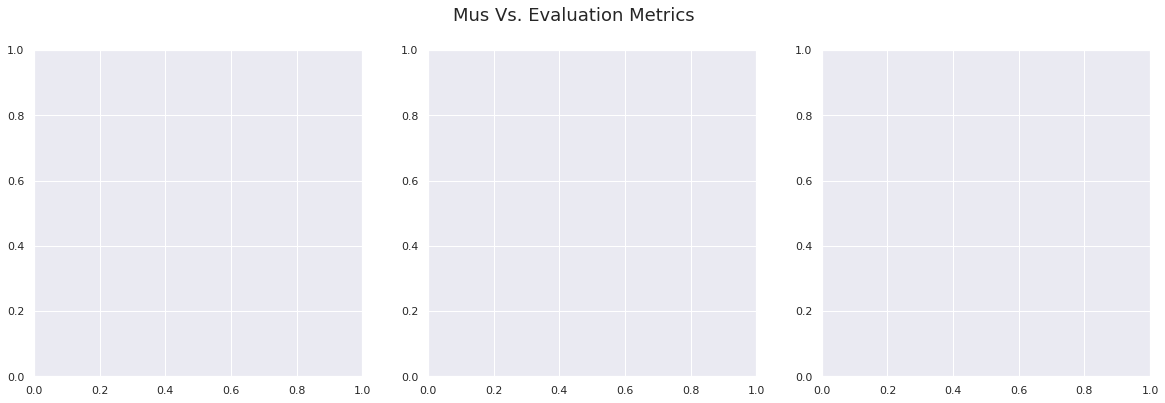

In [12]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.8
    icd best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.5
    icd best Mus on test: 0.2
========= PubMed:
    acc best Mus on test: 0.2
    icd best Mus on test: 0.0
